In [50]:
#INSTRUCTIONS TO RUN THIS NOTEBOOK
#-- run all cells in order, dont skip any cell
#-- the zip file has all the pre-computed indexes/pickle files, make sure you run the code in the same folder
#-- This code runs for 80-20 split ratio, it was very time taking for KNN to train so a particular top feature % is used for KNN 
#-- stay home! stay safe!
#-- zaki mustafa farooqi, MT19048; for any issues , let me know at zaki19048@iiitd.ac.in; your time is precious!!

In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import pickle
import os
import math
from collections import Counter
from num2words import num2words
import numpy as np
import sklearn.metrics.pairwise
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
ps = PorterStemmer()
import random
import dill
from collections import Counter 
from sklearn.metrics import confusion_matrix
import dill
import seaborn
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

C:\Users\K\anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def removeStopWords(words):
    filteredWords = []
    stop_words=stopwords.words('english')
    for word in words:
        if word not in stop_words:
            word = ps.stem(word)
            filteredWords.append(word)
    return filteredWords

def loadFromPickle(pickleFile):
	file = open(pickleFile,'rb')
	pickleData = pickle.load(file)
	file.close()
	return pickleData

In [7]:
 
    
def getAllFoldersPath():
	filesList=[]
	path="stories"
	filesList =  [x[0] for x in os.walk(path)]

	return filesList[1:]

def getNumWordFixed(fileContent):
    result = []
#     fileContent = fileContent.split()
    for word in fileContent:
            if(word.isnumeric()):
                word = int(word)
                word = num2words(word)
                tokenizer=RegexpTokenizer(r'([A-Za-z0-9]+)')
                tokensList=tokenizer.tokenize(word)
                result+=tokensList
            else:
                result.append(word)
                
    return result

In [8]:
def getAllTokens(foldersPathList):
    count=0
    docIdsSet = []
    docWordsDictionary = {}
    vocab = []
    for folderCount, path in enumerate(foldersPathList):
        docWordsDictionary[path] ={} 
        for r, d, f in os.walk(path):
            for file in f:
                filePath = os.path.join(r, file)
                fileReference = open(filePath, "r", encoding = "ISO-8859-1")
                fileContent=fileReference.read()
                fileContent = fileContent.lower()                
                tokenizer=RegexpTokenizer(r'([A-Za-z0-9]+)')
                tokensList=tokenizer.tokenize(fileContent)
                fileContent = getNumWordFixed(tokensList)
                filteredWords = removeStopWords(fileContent)
                docId = int(file)
#                 docId = docId*100+folderCount
                docIdsSet.append(docId)
                count+=len(filteredWords)
                docWordsDictionary[path][docId] = filteredWords
                vocab+=filteredWords
    return docWordsDictionary, list(set(vocab))

In [41]:
def splitDataSet(splitRatio, docWords):
    testData = {}
    trainData = {}
    for classLabel in docWords:
        testData[classLabel] = []
        trainData[classLabel] = []
        docs = docWords[classLabel]
        l = len(docs)
        docsItems = list(docs.items())
        random.shuffle(docsItems)  ## randomly shuffles docs 
        splitIndex = int(splitRatio*l/100)
        d1 = dict(docsItems[:splitIndex])
        d2 = dict(docsItems[splitIndex:])
        trainData[classLabel] = d1
        testData[classLabel] = d2
        
    return trainData, testData 
            

In [10]:
def getClassTfValues(trainData):
    classTf = {}
    count = 0
    for classLabel in trainData:
        classTf[classLabel] = {}
        words = []
        for doc in trainData[classLabel]:
            words +=trainData[classLabel][doc]
        words = dict(Counter(words))
        classTf[classLabel] = words
    return classTf

def getIdfVal(idfCount, N):
    return math.log(N/(1+idfCount), 10)

def tfVariant(freq):
    return 1 + math.log(freq, 10)

def getTrainVocab(classTf):
    trainVocab = []
    for classLabel in classTf:
        words = list(classTf[classLabel].keys())
#         print(words)
        trainVocab+=words
    trainVocab = list(set(trainVocab))
    return trainVocab 

def getIdf(trainVocab, classTf):
    idf = {}
    for word in trainVocab:
        count = 0
        for classLabel in classTf:
            if(word in classTf[classLabel]):
                count+=1
        idf[word] = getIdfVal(count, 5)
        
    return idf


In [11]:
def selectFeaturesUsingTfIdf(classTf, k, idf):
    classFeatures = {}
    for classLabel in classTf:
        features = []
        classFeatures[classLabel] = []
        for word in classTf[classLabel]:
            tf = tfVariant(classTf[classLabel][word])
            
            idfVal = idf[word]
#             print(idfVal)
            tfIdf = tf*idfVal
            features.append((word, tfIdf))
        features.sort(key = lambda x: x[1], reverse=True) 
        l = len(features)
        index = int(k*l/100)
        classFeatures[classLabel] = features[:index]
    return classFeatures



def getClassLabelsMap(foldersPathList):
    classLabelsMap = {}
    for i, label in enumerate(foldersPathList):
        classLabelsMap[label] = i
    return classLabelsMap

def getClassWordsCount(classTf):
    classWordsCount = {}
    for classLabel in classTf:
        classWordsCount[classLabel]  = sum(Counter(classTf[classLabel]).values())
    return classWordsCount
        
def getTrainFeaturesVocab(tfIdfFeatures):
    tfIdfVocab = []
    for classLabel in tfIdfFeatures:
        features = tfIdfFeatures[classLabel]
        words = [x[0] for x in features]
        tfIdfFeatures[classLabel] = words
        tfIdfVocab+=words
    tfIdfVocab = list(set(tfIdfVocab))
    return tfIdfVocab

In [12]:
def naiveBayesTfProb(tfIdfFeatures, tfIdfVocab):
    nbTfProb = {}
    for classLabel in tfIdfFeatures:
        nbTfProb[classLabel] = {}
        numWords = len(tfIdfFeatures[classLabel])
        for word in tfIdfFeatures[classLabel]: 
            tfVal = classTf[classLabel][word]
            p = (tfVal+1)/(numWords+len(tfIdfVocab))
            nbTfProb[classLabel][word] = p
    return nbTfProb

def naiveBayesUsingTfIdf(tfIdfFeatures, testData):
    trueLabels = []
    predictedLabels = []
    accuracy = 0
    for testClass in testData:
        for doc in testData[testClass]:
            trueLabels.append(classLabelsMap[testClass])
            testWords = testData[testClass][doc]
            maxProb = -math.inf
            for classLabel in tfIdfFeatures:  
                prob = math.log(1/5, 2)
                for word in testWords:
                    if(word in nbTfProb[classLabel]):
                        p = nbTfProb[classLabel][word]
                    else:
                        p = (1)/(classWordsCount[classLabel]+len(tfIdfVocab))
                    p = math.log(p,2)
                    prob+=p
#                 print(prob)
                if(prob > maxProb):
                    maxProb = prob
                    maxClassLabel = classLabel
            predictedLabels.append(classLabelsMap[maxClassLabel])
    
    return trueLabels, predictedLabels

In [13]:
####################  MI feature selection ####################

def getAccuracy(trueLabels, predictedLabels):
    accuracy = 0
    for i in range(len(trueLabels)):
        if(trueLabels[i]==predictedLabels[i]):
            accuracy+=1
    accuracy/=len(trueLabels)
    return accuracy*100

def getTfValues(trainData):
    tf = {}
    count = 0
    for classLabel in trainData:
        tf[classLabel] = {}
        for doc in trainData[classLabel]:
            words = trainData[classLabel][doc]
            words = dict(Counter(words))
            tf[classLabel][doc] = words
    return tf

def getMiValue(n11,n10,n01,n00):
    n00+=1
    n10+=1
    n11+=1
    n01+=1
#     print(n00, n10, n01, n11)
    n = n00+n11+n10+n01
    nt1 = n11+n10+1
    nc1 = n11+n01+1
    nt0 = n00 + n01+1
    nc0 = n00 + n10+1
    miValue = (n11/n)*math.log(n*n11/(nt1*nc1), 2)
    miValue += (n10/n)*math.log(n*n10/(nt1*nc0), 2)
    miValue += (n01/n)*math.log(n*n01/(nt0*nc1), 2)
    miValue += (n00/n)*math.log(n*n00/(nt0*nc0), 2)
    return miValue


def getClassWordDocDictionary(classTf, tf):
    classWordDoc  = {}
    for classLabel in tf:
        classWordDoc[classLabel] = {}
        for doc in tf[classLabel]:
            words = tf[classLabel][doc]
            for word in words:
                if(word not in classWordDoc[classLabel]):
                    classWordDoc[classLabel][word] = []
                classWordDoc[classLabel][word].append(doc)
            
    return classWordDoc

def generateFeaturesUsingMI(tf,classWordDoc, n):
    miFeatures = {}
    for classLabel in classWordDoc:
        print("classLabel:", classLabel)
        miFeatures[classLabel] = []
        for word in classWordDoc[classLabel]:
            n11 = len(classWordDoc[classLabel][word])
            n01 = len(tf[classLabel]) - n11
            n10 = 0
            for label in tf:
                for doc in tf[label]:
                    if(word in tf[label][doc] and label!=classLabel):
                        n10+=1
            n00 = n - n11-n01-n10
            miValue= getMiValue(n11,n10,n01,n00)
            miFeatures[classLabel].append((word, miValue))
    return miFeatures
        
    
def selectFeaturesUsingMI(miFeatures, k):
    selectedFeatures = {}
    for classLabel in miFeatures:
        features = miFeatures[classLabel]
        features.sort(key = lambda x: x[1], reverse=True) 
        l = len(features)
        index = int(k*l/100)
        selectedFeatures[classLabel] = features[:index]
    return selectedFeatures

In [14]:
def naiveBayesProb(features, vocab, classTf):
    nbProb = {}
    for classLabel in features:
        nbProb[classLabel] = {}
        numWords = len(features[classLabel])
        for word in features[classLabel]: 
            tfVal = classTf[classLabel][word]
            p = (tfVal+1)/(numWords+len(vocab))
            nbProb[classLabel][word] = p
    return nbProb

def naiveBayes(features, testData, nbProb, vocab):
    trueLabels = []
    predictedLabels = []
    accuracy = 0
    for testClass in testData:
        for doc in testData[testClass]:
            trueLabels.append(classLabelsMap[testClass])
            testWords = testData[testClass][doc]
            maxProb = -math.inf
            for classLabel in features:  
                prob = math.log(1/5, 2)
                for word in testWords:
                    if(word in nbProb[classLabel]):
                        p = nbProb[classLabel][word]
                    else:
                        p = (1)/(classWordsCount[classLabel]+len(vocab))
                    p = math.log(p,2)
                    prob+=p

                if(prob > maxProb):
                    maxProb = prob
                    maxClassLabel = classLabel
            predictedLabels.append(classLabelsMap[maxClassLabel])
    
    return trueLabels, predictedLabels

In [15]:
####################################################  K nearest neighbour ##########################

### using TfIdfFeatures


def generateTrainVectors(featureVocab, tf, trainSize):
    trainVectors = np.zeros(shape=(trainSize, len(featureVocab)))
    classDocs = {}
    count = 0
    for classLabel in tf: 
        classDocs[classLabel] = sorted(list(set(tf[classLabel].keys())))
        for doc in classDocs[classLabel]:
            vector = np.zeros(shape=(1,len(featureVocab)))
            words = list(tf[classLabel][doc].keys())
            for j, featureWord in enumerate(featureVocab):
                if(featureWord in words):
                    tfVal = tfVariant(tf[classLabel][doc][featureWord])
                    idfVal = idf[featureWord]
                    tfIdf = tfVal*idfVal
#                     print(tfVal, idfVal)
                    trainVectors[count][j] = tfIdf
                else:
                    trainVectors[count][j] = 0
            count+=1
        print(count)
        

    return trainVectors

def generateTestVectors(featureVocab, testData, testSize):
    testVectors = np.zeros(shape=(testSize, len(featureVocab)))
    count = 0
    for testClass in testData:
        for doc in testData[testClass]:
            testWords = testData[testClass][doc]
            for i, word in enumerate(featureVocab):
                if(word in testWords):
                    tfVal = tfVariant(testWords.count(word))
                    idfVal = idf[word]
                    tfIdf = tfVal*idfVal
                    testVectors[count][i] = tfIdf
                else:
                    testVectors[count][i] = 0
            count+=1
            print(count)
    return testVectors

def generateTestVector(vocab, testWords):
    testVector = np.zeros(shape=(1, len(vocab)))
    for i, word in enumerate(vocab):
        if(word in testWords):
            tfVal = tfVariant(testWords.count(word))
            idfVal = idf[word]
            tfIdf = tfVal*idfVal
#             print(tfVal, idfVal)
            testVector[0][i] = tfIdf
        else:
            testVector[0][i] = 0
    return testVector


def getPredictedResult(trainIndex, trainSize):
    classSize = trainSize/5
    result = {}
    for index in trainIndex:
        classId  = int(index/classSize)
        
        if(classId not in result):
            result[classId] = 0
        result[classId]+=1
    return max(result, key=result.get) 

In [51]:
def KNN(trainVectors, k, testVectors, vocab, trainSize):
    trueLabels = []
    predictedLabels = [] 
    for testClass in testData:
        for doc in testData[testClass]:
            trueLabels.append(classLabelsMap[testClass])
            testWords = testData[testClass][doc]
            testVector = generateTestVector(vocab, testWords)
            distMatrix = np.sum((trainVectors - testVector)**2, axis=1)
            trainIndex = distMatrix.argsort()[:k]
            result = getPredictedResult(trainIndex, trainSize)
            print("true:", testClass,", predicted:",foldersPathList[result])
            predictedLabels.append(result)
    return trueLabels, predictedLabels

def KNNfast(trainVectors, k, testVectors, vocab, trainSize, testSize):
    trueLabels = []
    predictedLabels = [] 
    distMatrix = -2 * np.dot(testVectors, trainVectors.T) + np.sum(trainVectors**2,    axis=1) + np.sum(testVectors**2, axis=1)[:, np.newaxis]
    testClassSize = testSize/5
    trainClassSize = trainSize/5
    for i in range(len(distMatrix)):
        testClassLabel = int(i/testClassSize)
        trueLabels.append(testClassLabel)
        trainDist =  distMatrix[i]
        trainIndex = trainDist.argsort()[:k]
        result = getPredictedResult(trainIndex, trainSize)
        print("true:", foldersPathList[testClassLabel],", predicted:",foldersPathList[result])
        predictedLabels.append(result)    
    
    return trueLabels, predictedLabels

def KNNFaster(trainVectors, k, testVectors, vocab, trainSize, testSize):
    trueLabels = []
    predictedLabels = [] 
    a = np.linalg.norm(testVectors, axis = 1, ord=2)
    b = np.linalg.norm(trainVectors, axis = 1, ord=2)
    a = a.reshape(testSize,1)
    b = b.reshape(1,trainSize)
    c = np.matmul(a, b)
    distMatrix =  np.dot(testVectors, trainVectors.T)/c
    testClassSize = testSize/5
    trainClassSize = trainSize/5
    for i in range(len(distMatrix)):
        testClassLabel = int(i/testClassSize)
        trueLabels.append(testClassLabel)
        trainDist =  distMatrix[i]
        trainIndex = trainDist.argsort()[-k:]
        result = getPredictedResult(trainIndex, trainSize)
#         print("true:", foldersPathList[testClassLabel],", predicted:",foldersPathList[result])
        predictedLabels.append(result)    
    
    return trueLabels, predictedLabels




In [17]:
def performanceGraph(performance):
    performance_curves = ["performance_80_20"]
    trainSizes = [trainSize]
    Knn135 = {}
    for i, path in enumerate(performance_curves):
        performance = loadFromPickle(path)
        nbTfIdf = performance[trainSizes[i]]["nb"]["tfidf"]
        nbMi = performance[trainSizes[i]]["nb"]["mi"]
        knnTfIdf = performance[trainSizes[i]]["knn"]["tfidf"]
        knnMi = performance[trainSizes[i]]["knn"]["mi"]
        
        
        ### overall split ratio wise comparison
        printmd("\n**Overall Comparsion for split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i])+"**\n")
        nbTfIdfPlot = getTestPointAccuracy(nbTfIdf)
        nbMiPlot = getTestPointAccuracy(nbMi)
        knnTfIdfPlot = getTestPointAccuracy(knnTfIdf[5])
        knnMiPlot = getTestPointAccuracy(knnMi[5])
        plt.figure(figsize = (9,7))
        plt.title("Overall Comparsion for split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i]))
        plt.plot(nbTfIdfPlot, label="Naive Bayes - TfIdf")
        plt.plot(nbMiPlot, label="Naive Bayes - Mutual Information")
        plt.plot(knnTfIdfPlot, label="KNN - TfIdf, K=5")
        plt.plot(knnMiPlot, label="KNN - Mutual Information, K=5")
        plt.legend(loc="bottom right")
        plt.xlabel('Number of Test documents', fontsize=14)
        plt.ylabel('Accuracy', fontsize=16)
        plt.show()
        
        ### Naive Bayes comparison

    for i, path in enumerate(performance_curves):
        performance = loadFromPickle(path)
        nbTfIdf = performance[trainSizes[i]]["nb"]["tfidf"]
        nbMi = performance[trainSizes[i]]["nb"]["mi"]
        knnTfIdf = performance[trainSizes[i]]["knn"]["tfidf"]
        knnMi = performance[trainSizes[i]]["knn"]["mi"]
        nbTfIdfPlot = getTestPointAccuracy(nbTfIdf)
        nbMiPlot = getTestPointAccuracy(nbMi)
        printmd("\n**Naive Bayes comparison split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i])+"**\n")
        plt.figure(figsize = (9,7))
        plt.title("Naive Bayes comparison split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i]))
        plt.plot(nbTfIdfPlot, label="Naive Bayes - TfIdf")
        plt.plot(nbMiPlot, label="Naive Bayes - Mutual Information")
        plt.legend(loc="bottom right")
        plt.xlabel('Number of Test documents', fontsize=14)
        plt.ylabel('Accuracy', fontsize=16)
        plt.show()
        
        
        
        ### KNN 1,3,5 comparison for each split ratio
    for i, path in enumerate(performance_curves):
        performance = loadFromPickle(path)
        nbTfIdf = performance[trainSizes[i]]["nb"]["tfidf"]
        nbMi = performance[trainSizes[i]]["nb"]["mi"]
        knnTfIdf = performance[trainSizes[i]]["knn"]["tfidf"]
        knnMi = performance[trainSizes[i]]["knn"]["mi"]
        
        
        printmd("\n**KNN comparison for K=1,3,5,  split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i])+"**\n")
        knnTfIdf5 = getTestPointAccuracy(knnTfIdf[5])
        knnMi5 = getTestPointAccuracy(knnMi[5])
        knnTfIdf3 = getTestPointAccuracy(knnTfIdf[3])
        knnMi3 = getTestPointAccuracy(knnMi[3])
        knnTfIdf1 = getTestPointAccuracy(knnTfIdf[1])
        knnMi1 = getTestPointAccuracy(knnMi[1])
        
        plt.figure(figsize = (9,7))
        plt.title("KNN - TfIdf comparison for K=1,3,5,  split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i]))
        plt.plot(knnTfIdf5, label="KNN - TfIdf, K=5")
        plt.plot(knnTfIdf3, label="KNN - TfIdf, K=3")
        plt.plot(knnTfIdf1, label="KNN - TfIdf, K=1")
        plt.legend(loc="bottom right")
        plt.xlabel('Number of Test documents', fontsize=14)
        plt.ylabel('Accuracy', fontsize=16)
        plt.show()
        
        plt.figure(figsize = (9,7))
        plt.title("KNN - Mutual Information comparison for K=1,3,5,  split-ratio :" + str(trainSizes[i])+"-" +str(100-trainSizes[i]))
        plt.plot(knnMi5, label="KNN - Mutual Information, K=5")
        plt.plot(knnMi3, label="KNN - Mutual Information, K=3")
        plt.plot(knnMi1, label="KNN - Mutual Information, K=1")
        plt.legend(loc="bottom right")
        plt.xlabel('Number of Test documents', fontsize=14)
        plt.ylabel('Accuracy', fontsize=16)
        plt.show()
        
def getTestPointAccuracy(labels):
    trueLabels = labels[0]
    predictedLabels = labels[1]
    accuracyList = []
    trueCount = 0
    for i in range(20, len(trueLabels)):
        if(trueLabels[i]==predictedLabels[i]):
            trueCount+=1
        accuracyList.append(trueCount/i)
    
    return accuracyList

In [18]:
def plotConfusionMatrix(trueLabels, predictedLabels):
    cfMatrix = confusion_matrix(trueLabels, predictedLabels)
    df_cm = pd.DataFrame(cfMatrix, index = [i for i in classList],
                      columns = [i for i in classList])
    plt.figure(figsize = (8,6))
    seaborn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')
    plt.ylabel('True class', color="g",size = 18)
    plt.xlabel('Predicted class', color="r",size = 18)
    plt.yticks(np.arange(6), classList, size = 12, rotation='horizontal')
    plt.xticks(np.arange(5), classList, size = 12, rotation='30')
    plt.show()


In [19]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


In [20]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [21]:
########################################################################
####################   Code execution starts from here #################

In [39]:
## defining classes and folder's paths, train:test split ratio
foldersPathList = ['20_newsgroups/comp.graphics', '20_newsgroups/sci.med',
'20_newsgroups/talk.politics.misc', '20_newsgroups/rec.sport.hockey', '20_newsgroups/sci.space']
classList = ['comp.graphics', 'sci.med',
'talk.politics.misc', 'rec.sport.hockey', 'sci.space']
trainSize = 80 ### like if trainSize = 80 then 80% data will be used for training, rest 20% will be used for testing
printmd("\n**----------------------Split Ratio 80-20----------------------------**\n")


**----------------------Split Ratio 80-20----------------------------**


In [23]:
## class wise document wise words dictionary
docWords = loadFromPickle("docWords")
## splitting was done and features are stored for that split already. (random splitting can be checked in splitDataSet() function)
trainData, testData = loadFromPickle("trainData"), loadFromPickle("testData")
classTf = getClassTfValues(trainData)
trainVocab = getTrainVocab(classTf)
idf = getIdf(trainVocab, classTf)


**Naive Bayes using TF-IDF with 76% features -- accuracy:92.2%**

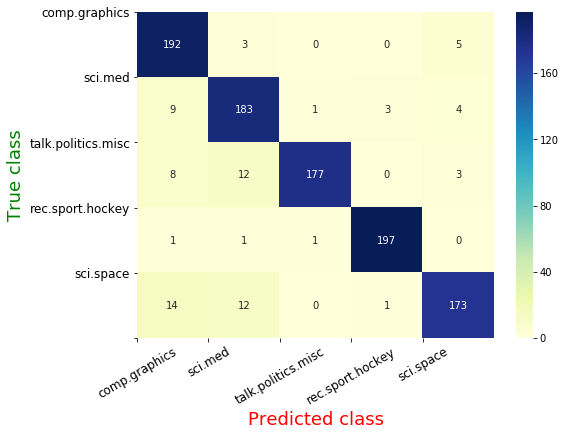

In [42]:

#### top % feature select 
featuresSelectPercent = 76
tfIdfFeatures = selectFeaturesUsingTfIdf(classTf, featuresSelectPercent, idf)
classLabelsMap = getClassLabelsMap(foldersPathList)
classWordsCount = getClassWordsCount(classTf)
tfIdfVocab = getTrainFeaturesVocab(tfIdfFeatures)

#### Training Naive Bayes using TF-IDF  feature selection
# print("Training Naive Bayes using TF-IDF  feature selection with ",featuresSelectPercent,"% features")
nbTfProb = naiveBayesTfProb(tfIdfFeatures, tfIdfVocab)
trueLabels, predictedLabels = naiveBayesUsingTfIdf(tfIdfFeatures, testData)
accuracy  = getAccuracy(trueLabels, predictedLabels)
printmd("\n**Naive Bayes using TF-IDF with "+str(featuresSelectPercent)+"% features -- accuracy:" + str(accuracy)+ "%**")
plotConfusionMatrix(trueLabels, predictedLabels)

In [43]:
## term frequency and class wise documents list
tf = getTfValues(trainData)
classWordDoc = getClassWordDocDictionary(classTf, tf)

In [44]:
####  generating MI features
# miFeatures = generateFeaturesUsingMI(tf, classWordDoc, 4000), loading pre-computed features for above train-test split dataset
miFeatures = loadFromPickle("miFeatures_80_20")


**Naive Bayes using Mutual Information with 91% features -- accuracy:90.5%**

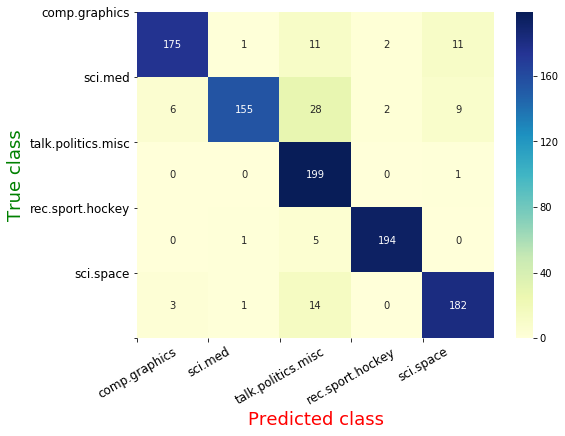

In [45]:
### Mutual information feature selection and Naive Bayes training
featuresSelectPercent = 91
# print("Training Naive Bayes using Mutual Information feature selection with ",featuresSelectPercent,"% features")
selectedFeatures = selectFeaturesUsingMI(miFeatures, featuresSelectPercent)
miVocab = getTrainFeaturesVocab(selectedFeatures)
nbMiProb = naiveBayesProb(selectedFeatures, miVocab, classTf)
trueLabels, predictedLabels = naiveBayes(selectedFeatures, testData, nbMiProb, miVocab)
accuracy = getAccuracy(trueLabels, predictedLabels)
printmd("\n**Naive Bayes using Mutual Information with "+str(featuresSelectPercent)+"% features -- accuracy:"+str(accuracy)+"%**")
plotConfusionMatrix(trueLabels, predictedLabels)
print("\n")



**KNN using TfIdf with k = 1 and 80% features -- accuracy:88.6%**


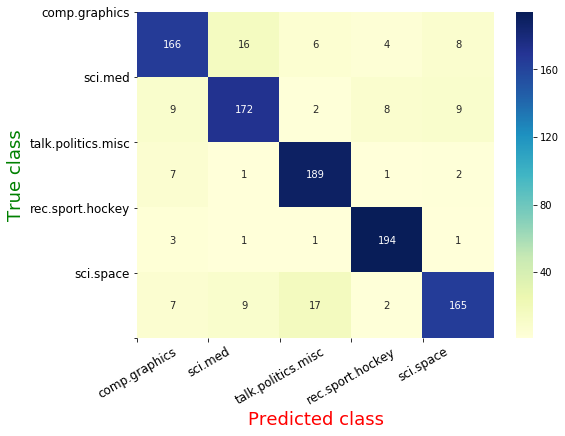



**KNN using TfIdf with k = 3 and 80% features -- accuracy:89.1%**


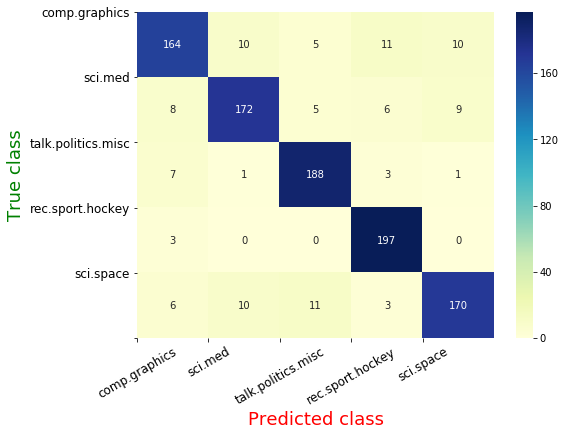



**KNN using TfIdf with k = 5 and 80% features -- accuracy:90.2%**


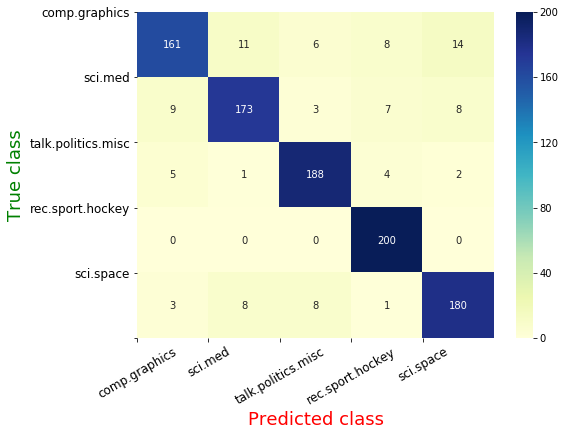

In [52]:
#KNN
####################################################  K nearest neighbour ##########################

### using TfIdfFeatures
featuresSelectPercent = 80

tfIdfFeatures = selectFeaturesUsingTfIdf(classTf, featuresSelectPercent, idf)
classLabelsMap = getClassLabelsMap(foldersPathList)
classWordsCount = getClassWordsCount(classTf)
tfIdfVocab = getTrainFeaturesVocab(tfIdfFeatures)

### generating test and train vectors
trainVectors = loadFromPickle("trainVectors_80_20_80%features")
testVectors = loadFromPickle("testVectors_80_20_80%features")
# trainVectors = generateTrainVectors(tfIdfVocab, tf, 2500)
# testVectors = generateTestVectors(tfIdfVocab, testData, 2500)

# performing KNN for K= 1,3,5, will take few seconds
kList = [1, 3, 5]
for k in kList:
    trueLabels, predictedLabels = KNNFaster(trainVectors, k, testVectors, tfIdfVocab, 4000, 1000)
    accuracy = getAccuracy(trueLabels, predictedLabels)
    printmd("\n\n**KNN using TfIdf with k = " + str(k) +" and " + str(featuresSelectPercent)+ "% features -- accuracy:" + str(accuracy) + "%**\n")
    plotConfusionMatrix(trueLabels, predictedLabels)
    print("\n\n")



**KNN using Mutual Information with k = 1 and 80% features -- accuracy:89.0%**


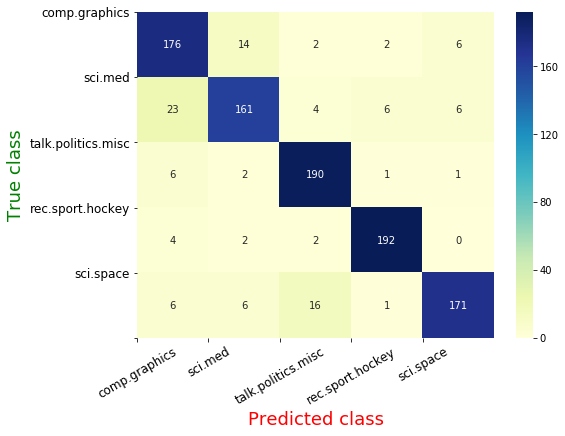



**KNN using Mutual Information with k = 3 and 80% features -- accuracy:87.7%**


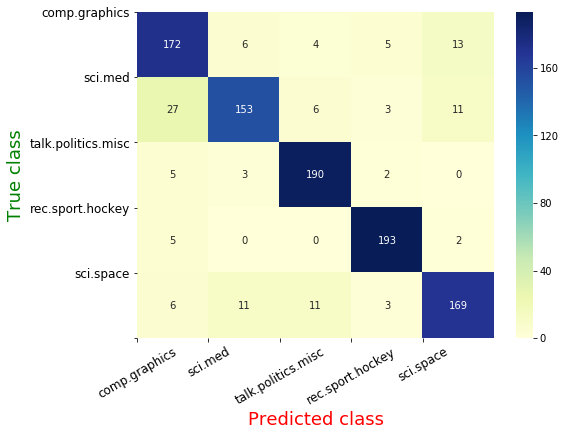



**KNN using Mutual Information with k = 5 and 80% features -- accuracy:90.3%**


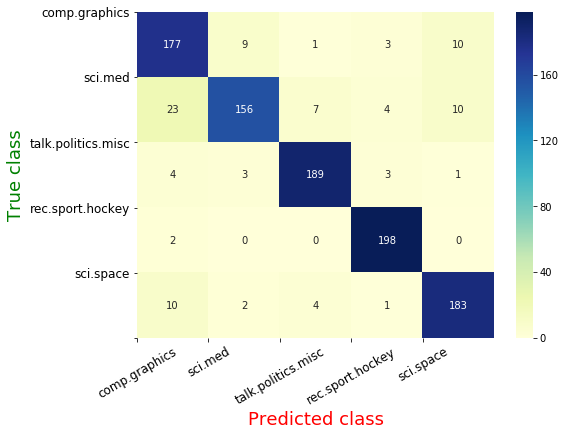

In [53]:
########### KNN using MI features ###############

## features selection and training vocab generation
featuresSelectPercent = 80
selectedFeatures = selectFeaturesUsingMI(miFeatures, featuresSelectPercent)
miVocab = getTrainFeaturesVocab(selectedFeatures)

## generating tets and train docs vectors based on feature selected above
trainMiVectors = loadFromPickle("trainVectors_mi_80_20_80%")
testMiVectors = loadFromPickle("testVectors_mi_80_20_80%")
# trainMiVectors = generateTrainVectors(miVocab, tf, 2500)
# testMiVectors = generateTestVectors(miVocab, testData, 2500)

# performing KNN for K= 1,3,5, will take few seconds
kList = [1, 3, 5]
for k in kList:
    trueLabels, predictedLabels = KNNFaster(trainMiVectors, k, testMiVectors, miVocab, 4000, 1000)
    accuracy = getAccuracy(trueLabels, predictedLabels)
    printmd("\n\n**KNN using Mutual Information with k = " + str(k) +" and " + str(featuresSelectPercent)+ "% features -- accuracy:" + str(accuracy) + "%**\n")
    plotConfusionMatrix(trueLabels, predictedLabels)


**Overall Comparsion for split-ratio :80-20**


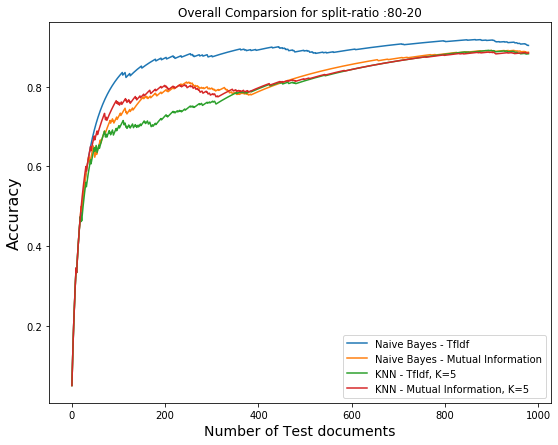


**Naive Bayes comparison split-ratio :80-20**


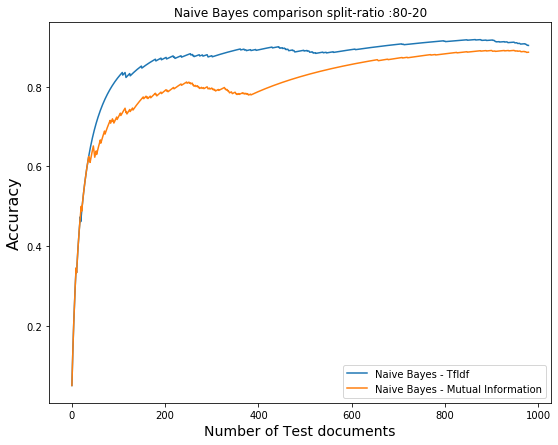


**KNN comparison for K=1,3,5,  split-ratio :80-20**


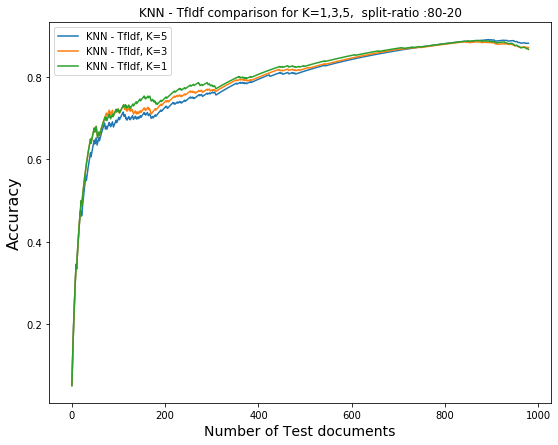

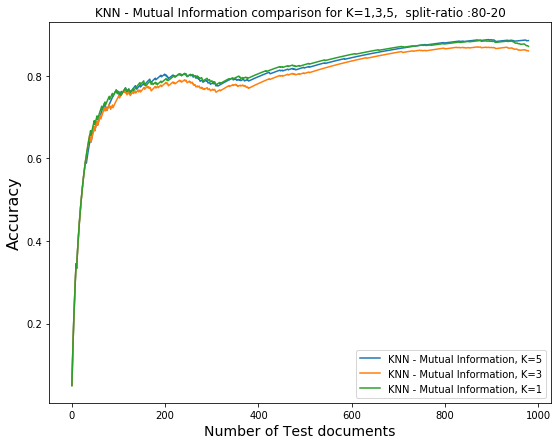

In [49]:
### performance curves for overall comparison
performance = loadFromPickle("performance_80_20")
performanceGraph(performance)